Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6351 - loss: 0.6666 - val_accuracy: 0.6402 - val_loss: 0.6539
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.6471 - loss: 0.6501 - val_accuracy: 0.6402 - val_loss: 0.6537
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6424 - loss: 0.6502 - val_accuracy: 0.6402 - val_loss: 0.6562
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.6428 - loss: 0.6521 - val_accuracy: 0.6402 - val_loss: 0.6531
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6343 - loss: 0.6520 - val_accuracy: 0.6402 - val_loss: 0.6551
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6462 - loss: 0.6458 - val_accuracy: 0.6402 - val_loss: 0.6525
Epoch 7/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.6380 - loss: 0.6478 - val_accuracy: 0.6402 - val_loss: 0.6523
Epoch 8/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.6365 - loss: 0.6507 - val_

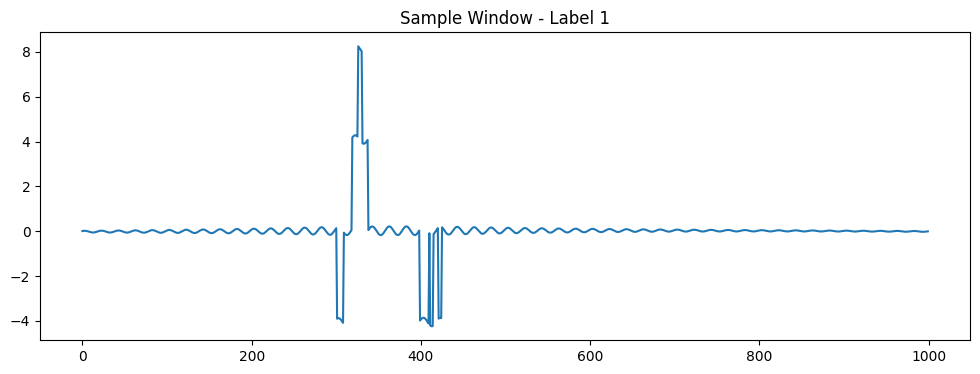

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install wfdb
import wfdb
from scipy import signal
import tensorflow as tf
from tensorflow.keras import layers, models

# -----------------------------
# Configuration
# -----------------------------
RECORDS = ['100', '101', '102']      # add more MIT-BIH record IDs
SAMPLE_RATE = 360                   # MIT‑BIH sample rate
TARGET_SR = 1000                    # target 1kHz for STM32 compatibility
WINDOW_LENGTH = 1000                # samples per window (1s at 1kHz)
OVERLAP = 0                         # no overlap

# AD8232 voltage conversion parameters
ADC_BITS = 12
V_REF = 3.3
ADC_MAX = 2**ADC_BITS - 1
DC_OFFSET = 1.65                    # mid‑rail offset

# Filtering design: 50Hz notch + 0.5Hz high‑pass
b_notch, a_notch = signal.iirnotch(50, 30, TARGET_SR)
b_hp, a_hp = signal.butter(2, 0.5/(TARGET_SR/2), btype='highpass')

# -----------------------------
# Functions
# -----------------------------
def load_record(record_id):
    # Read raw signal and annotations
    rec = wfdb.rdrecord(record_id, sampfrom=0, channels=[0])
    ann = wfdb.rdann(record_id, 'atr')
    sig = rec.p_signal.flatten()  # original amplitude in mV
    return sig, ann

def resample_to_target(sig):
    # Resample from 360Hz to 1000Hz
    return signal.resample(sig, int(len(sig) * TARGET_SR / SAMPLE_RATE))

def preprocess_window(win):
    # Convert ECG mV -> ADC counts -> voltage -> remove DC -> filter -> back to float
    # 1. Simulate ADC reading
    counts = np.clip(((win/1000.0 + DC_OFFSET) * ADC_MAX / V_REF), 0, ADC_MAX).astype(np.int16)
    # 2. Back to voltage
    volts = counts * (V_REF / ADC_MAX)
    # 3. Remove DC
    centered = volts - DC_OFFSET
    # 4. Filters
    notch = signal.filtfilt(b_notch, a_notch, centered)
    hp = signal.filtfilt(b_hp, a_hp, notch)
    return hp

def generate_windows(sig, ann):
    X, y = [], []
    # Slide window
    step = WINDOW_LENGTH - OVERLAP
    for start in range(0, len(sig) - WINDOW_LENGTH + 1, step):
        win = sig[start:start+WINDOW_LENGTH]
        # Check if any beat annotation falls in this window
        labels = [idx for idx in ann.sample if start <= idx < start+WINDOW_LENGTH]
        label = 1 if len(labels) > 0 else 0
        X.append(preprocess_window(win))
        y.append(label)
    return X, y

# -----------------------------
# Build dataset
# -----------------------------
all_X, all_y = [], []
for rec_id in RECORDS:
    sig, ann = load_record(rec_id)
    sig1000 = resample_to_target(sig)
    Xr, yr = generate_windows(sig1000, ann)
    all_X.extend(Xr)
    all_y.extend(yr)

X = np.array(all_X)[..., np.newaxis]
y = np.array(all_y)

# Normalize per window
X = (X - np.mean(X, axis=1, keepdims=True)) / (np.std(X, axis=1, keepdims=True) + 1e-8)

# Train/validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# -----------------------------
# Model Definition
# -----------------------------
def create_ecg_model(input_shape=(WINDOW_LENGTH, 1)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(16, 5, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Conv1D(32, 5, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 5, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# -----------------------------
# Training
# -----------------------------
model = create_ecg_model()
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)

model.save("ecg_anomaly_detector_optimized.keras")

# -----------------------------
# Visualize a sample
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(X_train[0].squeeze())
plt.title(f"Sample Window - Label {y_train[0]}")
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
with open('ecg_anomaly_detector_optimized.tflite', 'wb') as f:
    f.write(tflite_model)
from google.colab import files
files.download('ecg_anomaly_detector_optimized.tflite')

Saved artifact at '/tmp/tmpk39pe4wr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1000, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140156054310544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054311312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054310928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054314192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054313424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054315152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054314576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054315536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054313808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054316880: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('ecg_anomaly_detector_no.tflite', 'wb') as f:
    f.write(tflite_model)
from google.colab import files
files.download('ecg_anomaly_detector_no.tflite')

Saved artifact at '/tmp/tmp86vfm4ut'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1000, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140156054310544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054311312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054310928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054314192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054313424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054315152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054314576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054315536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054313808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156054316880: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

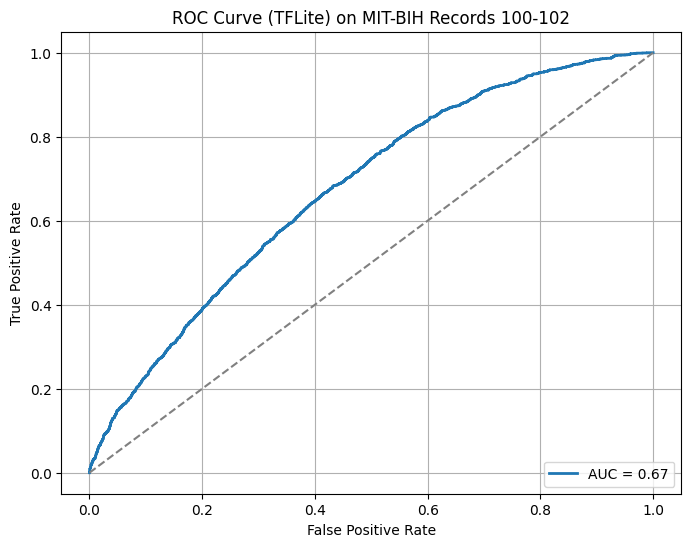

Best threshold = 0.412
At this threshold, TPR = 0.68, FPR = 0.43
Threshold for FPR<=0.30 is 0.452
  → TPR=0.52, FPR=0.30


In [ ]:
# Install dependencies (run once)
!pip install wfdb

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wfdb
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# ——— Config ———
RECORDS   = ['100', '101', '102']   # your 3 MIT-BIH records
MITBIH_SR = 360
TARGET_SR = 1000
WIN_LEN   = 1000
OVERLAP   = 0

# ADC & filters (must match your driver training pipeline)
ADC_BITS  = 12
V_REF     = 3.3
ADC_MAX   = 2**ADC_BITS - 1
DC_OFFSET = 1.65
b_notch, a_notch = signal.iirnotch(50, 30, TARGET_SR)
b_hp,    a_hp    = signal.butter(2, 0.5/(TARGET_SR/2), btype='highpass')

def preprocess(win_mv):
    # 1) ADC quant
    counts = np.clip(((win_mv/1000.0 + DC_OFFSET) * ADC_MAX / V_REF), 0, ADC_MAX).astype(np.int16)
    # 2) to volts
    volts = counts * (V_REF / ADC_MAX)
    # 3) remove DC
    cen = volts - DC_OFFSET
    # 4) notch + HPF
    f1 = signal.filtfilt(b_notch, a_notch, cen)
    f2 = signal.filtfilt(b_hp,    a_hp,    f1)
    return f2

# ——— Build Test Set ——
X_list, y_list = [], []
for rec_id in RECORDS:
    rec = wfdb.rdrecord(rec_id, channels=[0])
    ann = wfdb.rdann(rec_id, 'atr')
    sig = rec.p_signal.flatten()                         # mV
    sig1k = signal.resample(sig, int(len(sig)*TARGET_SR/MITBIH_SR))

    step = WIN_LEN - OVERLAP
    for start in range(0, len(sig1k)-WIN_LEN+1, step):
        win = sig1k[start:start+WIN_LEN]
        proc = preprocess(win)
        beats = [i for i in ann.sample if start <= i < start+WIN_LEN]
        label = 1 if beats else 0

        X_list.append(proc)
        y_list.append(label)

X = np.array(X_list)[..., np.newaxis].astype(np.float32)
y = np.array(y_list)

# ——— Normalize per window ———
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

# —— Load TFLite model ———
interpreter = tf.lite.Interpreter(model_path="/content/ecg_anomaly_detector_no.tflite")
interpreter.allocate_tensors()
input_idx  = interpreter.get_input_details()[0]["index"]
output_idx = interpreter.get_output_details()[0]["index"]

# ——— Run inference window by window ———
y_scores = []
for window in X:
    interpreter.set_tensor(input_idx, window[np.newaxis, ...]) # Add batch dimension of 1
    interpreter.invoke()
    out = interpreter.get_tensor(output_idx).ravel()
    y_scores.extend(out)
y_scores = np.array(y_scores)

# ——— ROC & AUC ———
fpr, tpr, thresholds   = roc_curve(y, y_scores)
roc_auc       = auc(fpr, tpr)

# ——— Plot ———
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', lw=2)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (TFLite) on MIT-BIH Records 100-102') # Update title
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

from sklearn.metrics import roc_curve
import numpy as np

# y: your ground-truth labels (0 or 1)
# y_scores: model’s sigmoid outputs

fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute Youden's J for each threshold
J = tpr - fpr

# Find the index of the maximum J
ix = np.argmax(J)

best_thresh = thresholds[ix]
best_tpr    = tpr[ix]
best_fpr    = fpr[ix]

print(f"Best threshold = {best_thresh:.3f}")
print(f"At this threshold, TPR = {best_tpr:.2f}, FPR = {best_fpr:.2f}")

# given arrays fpr, tpr, thresholds from roc_curve
#desired_fpr = 0.20
# find the first threshold where FPR ≤ desired_fpr
#idx = np.where(fpr <= desired_fpr)[0][0]
#practical_thresh = thresholds[idx]
#print(f"Threshold for FPR<={desired_fpr:.2f} is {practical_thresh:.3f}")
#print(f"  → TPR at that point is {tpr[idx]:.2f}, FPR is {fpr[idx]:.2f}")

desired_fpr = 0.30
idx = np.where(fpr <= desired_fpr)[0]
if len(idx)>0:
    # smallest threshold that meets your FPR target
    practical_thresh = thresholds[idx[-1]]
    print(f"Threshold for FPR<={desired_fpr:.2f} is {practical_thresh:.3f}")
    print(f"  → TPR={tpr[idx[-1]]:.2f}, FPR={fpr[idx[-1]]:.2f}")
else:
    print("No threshold can achieve that low FPR.")